<a href="https://colab.research.google.com/github/haldonmez/mnist-digit-recognizer/blob/main/Model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch import nn

import matplotlib.pyplot as plt

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

print(f"Pytorch version: {torch.__version__}\ntorchvision version:{torchvision.__version__}")

Pytorch version: 2.2.1+cu121
torchvision version:0.17.1+cu121


In [3]:
data = "/content/data"
train_data = datasets.MNIST(
    root=data,
    train= True,
    transform=ToTensor(),
    download=True,
    target_transform=None
)

test_data = datasets.MNIST(
    root=data,
    train=False,
    transform=ToTensor(),
    download=True
)

100%|██████████| 9912422/9912422 [00:00<00:00, 49714228.78it/s]


Extracting /content/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 60811091.28it/s]


Extracting /content/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 44248678.13it/s]


Extracting /content/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11951398.22it/s]

Extracting /content/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/MNIST/raw



In [4]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, #Dataset to iterate on for the according batch size.
                              batch_size = BATCH_SIZE, #Size of every single iteration.
                              shuffle = True, #To make the loaded data selecte randomly.
                              )
test_dataloader = DataLoader(test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = True)

print(f"For training data there is {len(train_dataloader)} iterations with the batch size of {BATCH_SIZE}.")
print(f"For testing data there is {len(test_dataloader)} iterations with the batch size of {BATCH_SIZE}.")

For training data there is 1875 iterations with the batch size of 32.
For testing data there is 313 iterations with the batch size of 32.


Lets try to get a optimum variance value by self picking 0-1 as background values and the rest as foreground values.

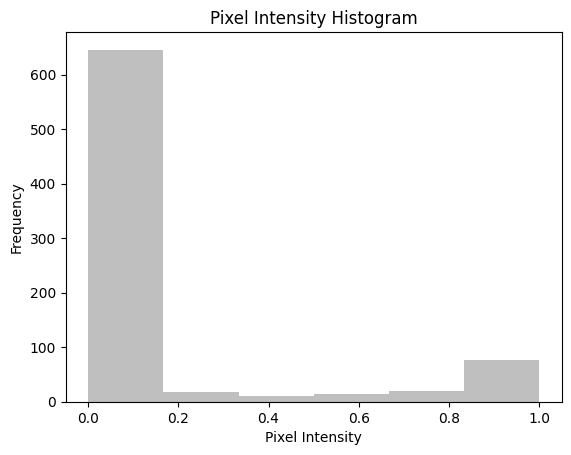

646.0
17.0
10.0
15.0
20.0
76.0


(0.25970596455305495,
 0.8456632653061225,
 0.15433673469387754,
 0.004273504400864625,
 0.7231404874935623,
 1.0,
 0.7274139918944269)

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import math
# Get an example image and a label.
image, label = train_data[0]

# Flattened the image so we can get the values in a single 1d matrix.
flatten_image = nn.Flatten()
image_flattened = flatten_image(image)

# Creating a histogram to check the mean of the background and foreground.
hist, bin_edges, number_of_x_values= plt.hist(image_flattened, bins=6, color='gray', alpha=0.5)
plt.title('Pixel Intensity Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

# We can calculate back to 784 and check if the histogram is correct.
total_weight = np.sum(hist)

# The sum of the values varying to their intensity levels.
for i in range(len(bin_edges)-1):
  print(hist[i])

# Weight values calculated for self-picked value of 0-1 to background and the rest for foreground.
Wb = (hist[0]+hist[1])/total_weight
Wf = (hist[2]+hist[3]+hist[4]+hist[5])/total_weight

# Calculating the mean variance of the background and foreground values which we self picked before hand.
Ub = ((hist[0]*bin_edges[0])+(hist[1]*bin_edges[1]))/(hist[0]+hist[1])
Uf = ((hist[2]*bin_edges[2])+(hist[3]*bin_edges[3])+(hist[4]*bin_edges[4])+(hist[5]*bin_edges[5]))/(hist[2]+hist[3]+hist[4]+hist[5])

# Getting the variance value based on Otsu's Method to get a number if our self picked number's variance is the best.
variance = math.sqrt((Wb*Wf)*((Ub-Uf)*(Ub-Uf)))
variance, Wb, Wf, Ub, Uf, Wb+Wf, Ub+Uf

This snippet calculates a variance number based on our self picked values which is "0.25970596455305495". We need to functionize this to get the best - highest - variance value to implement in our Otsu's threshold method.

In [ ]:
import numpy as np
def threshold_image(im,th):
    thresholded_im = np.zeros(im.shape)
    thresholded_im[im >= th] = 1
    return thresholded_im

In [ ]:
im_otsu = threshold_image(image, variance)

Text(0.5, 1.0, "After Otsu's model")

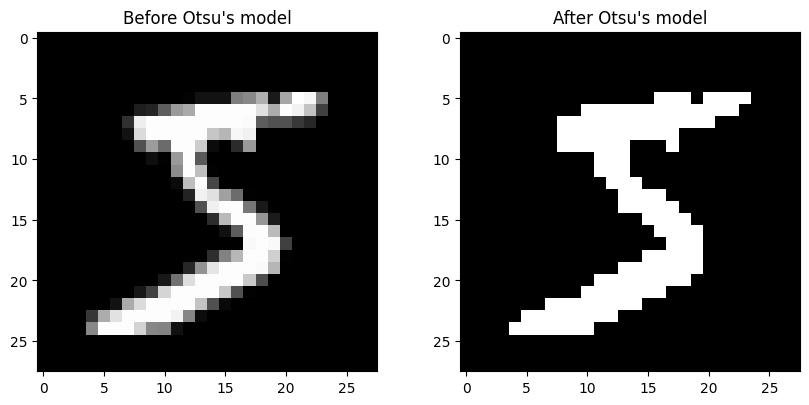

In [ ]:
plt.figure(figsize=(10,15))
plt.subplot(321); plt.imshow(image.squeeze(),cmap='gray')
plt.title("Before Otsu's model")
plt.subplot(322); plt.imshow(im_otsu.squeeze(),cmap='gray')
plt.title("After Otsu's model")

Lets functionize Otsu's model to get the optimal variance based of our given image.

In [29]:
"""import matplotlib.pyplot as plt
import numpy as numpy
import math

def findGreatestThreshold(img):
  # First we flatten the image to get the 1D matrix.
  flatten_image = nn.Flatten()
  image_flattened = flatten_image(image)

  # Then we get the histogram values of the image.
  counts, binominal_values, number_of_x_values= plt.hist(image_flattened, bins=6, color='gray', alpha=0.5)
  # Counts = The number of times that intensity was displayed
  # Binominal_values = The levels of intensity in our case its [0., 0.16666667, 0.33333334, 0.5, 0.66666669, 0.83333331, 1.]

  # We get the total weight for our calculations.
  total_weight = np.sum(counts)

  current_weight = 0
  current_intensity = 0
  foreground_intensity = 0

  for i in range(len(binominal_values)-1):
    for j in range(i+1):
      current_weight += counts[j]
      current_intensity += counts[j]*binominal_values[j]
    for k in range(len(binominal_values)-i-1):
      foreground_intensity += counts[k]*binominal_values[k]

    Ub = current_intensity / current_weight
    Uf = foreground_intensity / current_weight
    Wb = current_weight / total_weight
    Wf = 1 - Wb
    #variance = math.sqrt((Wb*Wf)*((Ub-Uf)*(Ub-Uf)))

  return Ub

findGreatestThreshold(image)"""

"import matplotlib.pyplot as plt\nimport numpy as numpy\nimport math\n\ndef findGreatestThreshold(img):\n  # First we flatten the image to get the 1D matrix.\n  flatten_image = nn.Flatten()\n  image_flattened = flatten_image(image)\n\n  # Then we get the histogram values of the image.\n  counts, binominal_values, number_of_x_values= plt.hist(image_flattened, bins=6, color='gray', alpha=0.5)\n  # Counts = The number of times that intensity was displayed\n  # Binominal_values = The levels of intensity in our case its [0., 0.16666667, 0.33333334, 0.5, 0.66666669, 0.83333331, 1.]\n\n  # We get the total weight for our calculations.\n  total_weight = np.sum(counts)\n\n  current_weight = 0\n  current_intensity = 0\n  foreground_intensity = 0\n\n  for i in range(len(binominal_values)-1):\n    for j in range(i+1):\n      current_weight += counts[j]\n      current_intensity += counts[j]*binominal_values[j]\n    for k in range(len(binominal_values)-i-1):\n      foreground_intensity += counts[k]*

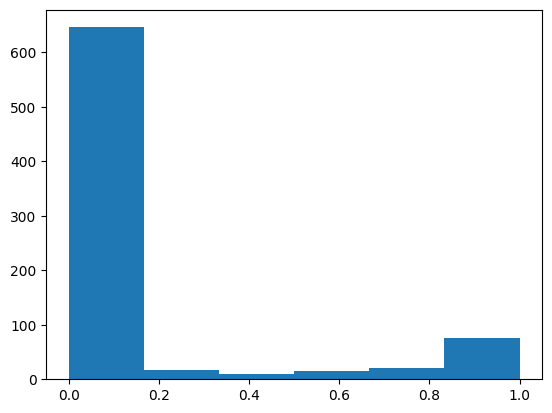

In [70]:
import matplotlib.pyplot as plt

flatten_image = nn.Flatten()
image_flattened = flatten_image(image)

image_flattened.shape
List = image_flattened.tolist()
List

fig, ax = plt.subplots()
ax.hist(List, bins=6)
plt.show()

